# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

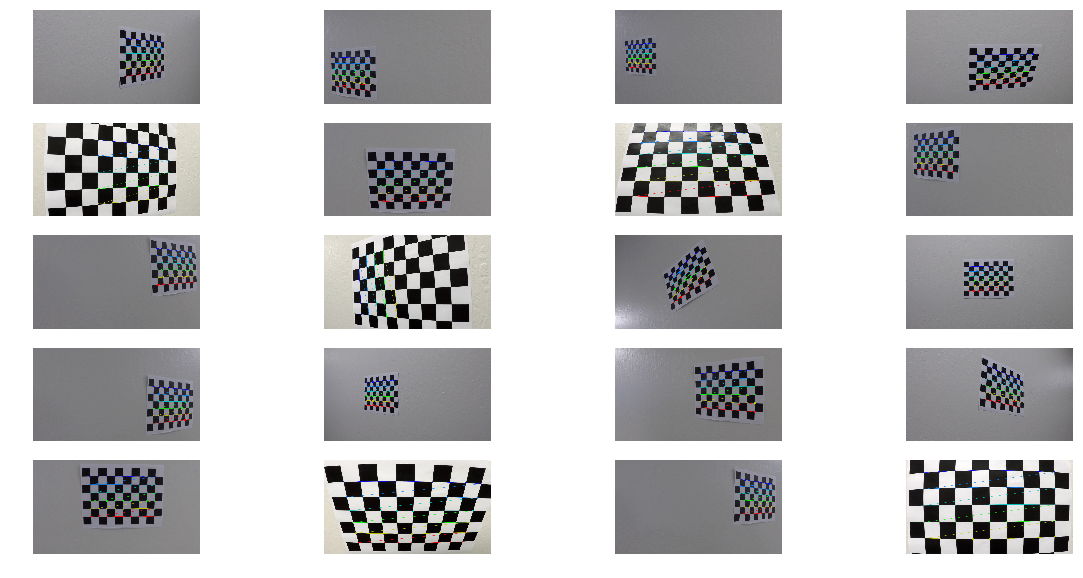

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
def get_object_points(size):
    objp = np.zeros((size[0]*size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:size[0],0:size[1]].T.reshape(-1,2)
    return objp

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# prepare pattern size
pattern_sizes = [(9,6),(9,5),(6,5),(7,5)]

# Step through the list and search for chessboard corners
i = 1
plt.figure(figsize=(20, 10))
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    for size in pattern_sizes:
        ret, corners = cv2.findChessboardCorners(gray, size, None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(get_object_points(size))
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, size, corners, ret)
            plt.subplot(5, 4, i)
            plt.axis('off')
            plt.imshow(img)
            i+=1
            break

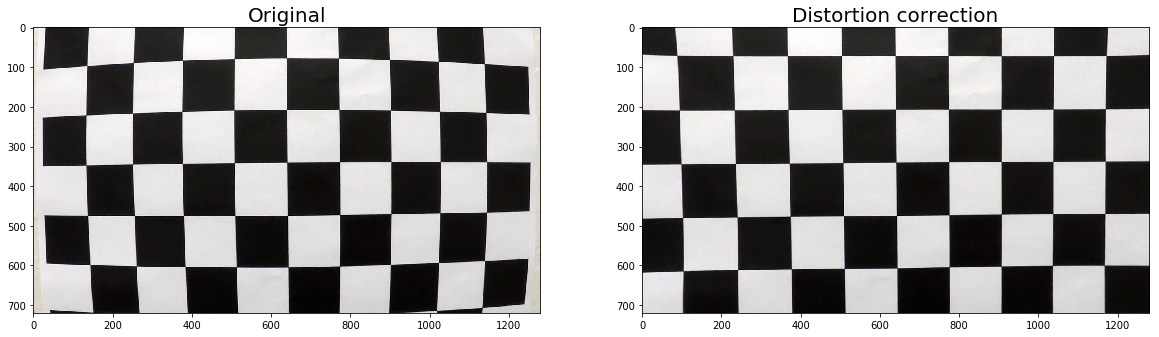

In [3]:
# Test image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
mpimg.imsave('output_images/undistort_output.png', dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Distortion correction', fontsize=20)

In [4]:
# Save the matrix and distortion coefficients
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_dist_pickle.p", "wb"))

# Image Pipeline

In [5]:
# Load pickled matrix and distortion coefficients
import pickle

with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

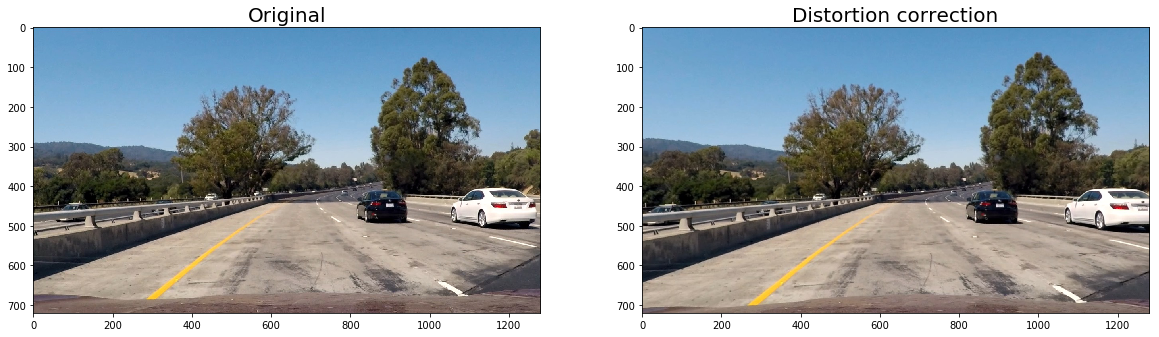

In [6]:
# Undistortion Test
test_img = mpimg.imread('test_images/test1.jpg')
undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)
mpimg.imsave('output_images/undistort_test_output.png', undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(undist_img)
ax2.set_title('Distortion correction', fontsize=20)

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def hls_thresh(img, thresh=(100, 255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

    return combined

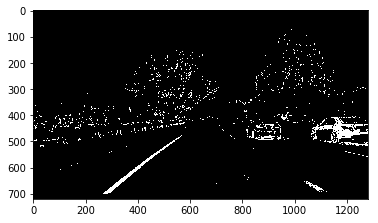

In [8]:
plt.imshow(combined_thresh(undist_img), cmap='gray')
mpimg.imsave('output_images/combined_thresh.png', combined_thresh(undist_img), cmap='gray')

In [9]:
def get_vertices(img):
    x_dim = img.shape[1]
    y_dim = img.shape[0]
    vertices = np.array([[(50,y_dim),(x_dim/2-10,y_dim/1.75),(x_dim/2+10,y_dim/1.75),(x_dim-50,y_dim),(50,y_dim)]], dtype=np.int32)
    return vertices

def region_of_interest(img):
    # get vertices
    vertices = get_vertices(img)
    # defining a blank mask to start with
    mask = np.zeros_like(img)
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 1)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

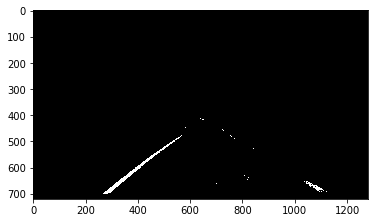

In [10]:
plt.imshow(region_of_interest(combined_thresh(undist_img)), cmap='gray')
mpimg.imsave('output_images/combined_thresh_roi.png', region_of_interest(combined_thresh(undist_img)), cmap='gray')

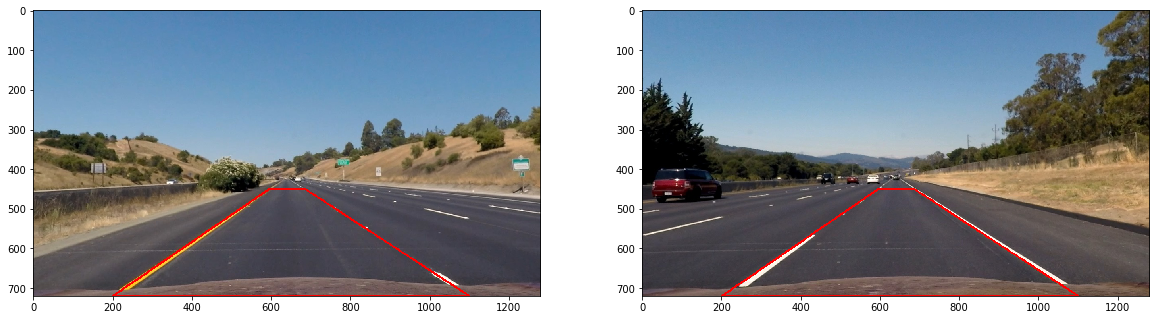

In [11]:
# Draw source points
src = np.float32([[200, 720],[595, 450],[685, 450],[1100, 720],[200, 720]])
images = glob.glob('test_images/straight_lines*.jpg')
result = []
for fname in images:
    img = mpimg.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    for i in range(len(src)-1):
        cv2.line(img, (src[i][0], src[i][1]), (src[i+1][0], src[i+1][1]), color=[255,0,0], thickness=3)
    result.append(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(result[0])
ax2.imshow(result[1])
mpimg.imsave('output_images/source_points.png', result[0])

In [12]:
# Perspective Transform
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[200,720],[595,450],[685,450],[1100,720]])
    dst = np.float32([[300,720],[300,0],[980,0],[980,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv, cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

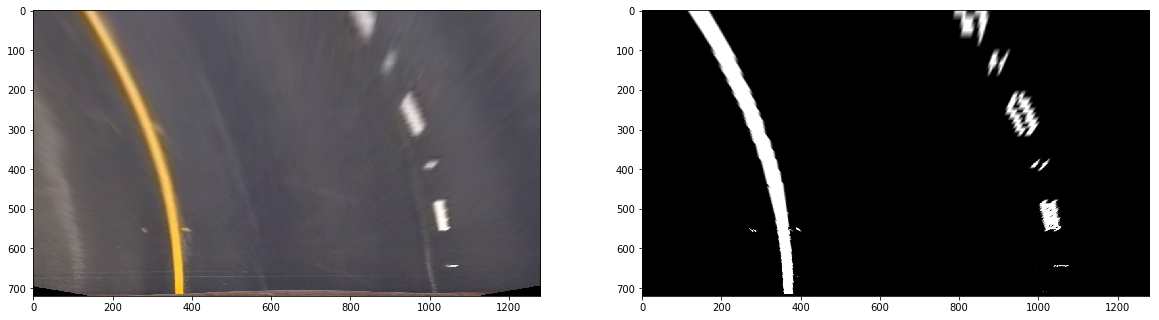

In [13]:
img = mpimg.imread('test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
_, warped = perspective_transform(undist)
_, binary_warped = perspective_transform(region_of_interest(combined_thresh(undist)))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax2.imshow(binary_warped, cmap='gray')
mpimg.imsave('output_images/warped.png', warped)
mpimg.imsave('output_images/binary_warped.png', binary_warped, cmap='gray')

In [14]:
def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

In [15]:
def fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [16]:
def show_lines(binary_warped, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

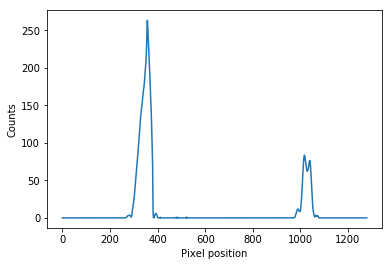

In [17]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.savefig('output_images/histogram.png')

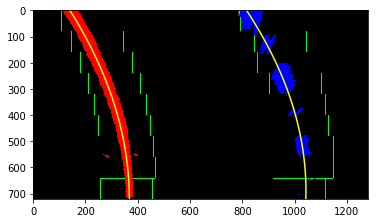

In [18]:
out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines(binary_warped)
show_lines(binary_warped, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
plt.savefig('output_images/sliding_window.png')

In [19]:
def get_curverad(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    y_eval = binary_warped.shape[0]-1
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [20]:
def get_offset(undist, left_fit, right_fit):
    # Calculate vehicle center offset
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    return offset * xm_per_pix

In [21]:
def draw_lines(undist, warped, left_fit, right_fit, Minv, left_curverad, right_curverad, offset):
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Curvature: {} m".format(round(left_curverad, 3))
    cv2.putText(result, text, (400, 50), font, 1, (255,255,255), 2)
    text = "Right Curvature: {} m".format(round(right_curverad, 3))
    cv2.putText(result, text, (400, 100), font, 1, (255,255,255), 2)
    text = "Distance from center: {} m".format(round(offset, 3))
    cv2.putText(result, text,(400,150), font, 1, (255,255,255), 2)
    
    return result

In [22]:
def single_pipeline(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = region_of_interest(combined_thresh(undist))
    Minv, binary_warped = perspective_transform(binary)
    _, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines(binary_warped)
    left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    left_curverad, right_curverad = get_curverad(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    offset = get_offset(undist, left_fit, right_fit)
    return draw_lines(undist, binary_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, offset)

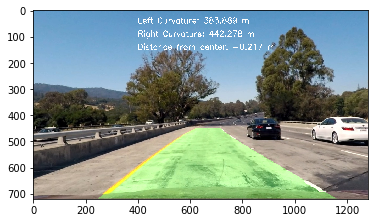

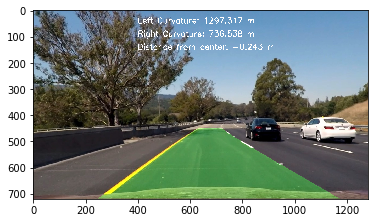

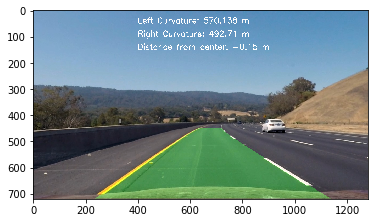

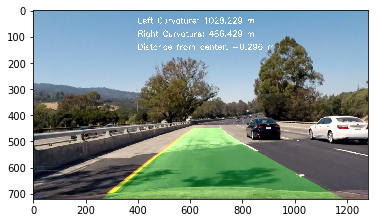

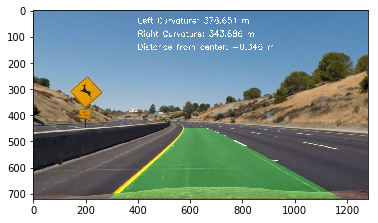

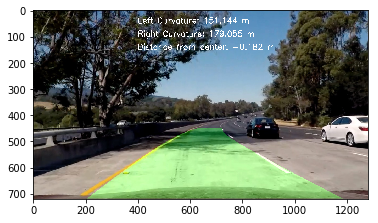

In [23]:
images = glob.glob('test_images/test*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    plt.imshow(single_pipeline(img, mtx, dist))
    plt.figure()

In [24]:
final = single_pipeline(mpimg.imread('test_images/test6.jpg'), mtx, dist)
mpimg.imsave('output_images/final.png', final)

## Video Pipeline

In [25]:
def find_lines_by_previous(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    return nonzerox, nonzeroy, left_lane_inds, right_lane_inds

In [26]:
def show_lines_by_previous(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin = 100
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

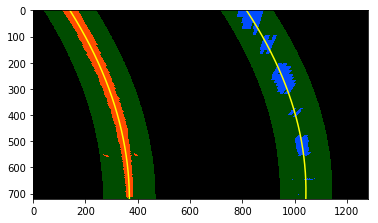

In [27]:
left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines_by_previous(binary_warped, left_fit, right_fit)
show_lines_by_previous(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
plt.savefig('output_images/skip_sliding_window.png')

In [28]:
from collections import deque

class Lanes():
    def __init__(self):
        self.detected = False
        self.left_fits = deque([], 5)
        self.right_fits = deque([], 5)
        
    def update(self, left_fit, right_fit):
        if self.line_check(left_fit, right_fit):
            self.detected = True
            self.left_fits.append(left_fit)
            self.right_fits.append(right_fit)
        else:
            self.detected = False
            self.left_fits.append(self.left_fits[-1])
            self.right_fits.append(self.right_fits[-1])
        
    def line_check(self, left_fit, right_fit):
        top_y = 0
        top_x_left = left_fit[2]
        top_x_right = right_fit[2]
        bottom_y = 719
        bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
        bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
        
        bottom_diff = bottom_x_right - bottom_x_left
        top_diff = top_x_right - top_x_left
        
        return abs(bottom_diff - top_diff) < 100
    
    def left_fit(self):
        return np.mean(np.array(self.left_fits), axis=0)
    
    def right_fit(self):
        return np.mean(np.array(self.right_fits), axis=0)

lanes = Lanes()
def video_pipeline(img):
    global lanes
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = region_of_interest(combined_thresh(undist))
    Minv, binary_warped = perspective_transform(binary)
    if lanes.detected:
        nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines_by_previous(binary_warped, lanes.left_fit(), lanes.right_fit())
    else:
        _, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines(binary_warped)
    left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    lanes.update(left_fit, right_fit)
    left_curv, right_curv = get_curverad(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    offset = get_offset(undist, left_fit, right_fit)
    return draw_lines(undist, binary_warped, lanes.left_fit(), lanes.right_fit(), Minv, left_curv, right_curv, offset)

In [29]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(video_pipeline)
video_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:49<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

